In [1]:
##### TORCH DATA GEN #####   Using realistic reflection angles dosnet give the number of reflections desired 
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import torch


def fill_circle_circumference(array, origin, radius, fill_value=1, angle_step=0.01, time_dimension=100):
    """
    Fill the circumference of a circle in a NumPy array.
    
    Parameters:
    - array (numpy.ndarray): The input NumPy array.
    - center_x (int): X-coordinate of the center of the circle.
    - center_y (int): Y-coordinate of the center of the circle.
    - radius (int): Radius of the circle.
    - fill_value (optional): Value to fill in the circumference. Default is 1.
    - angle_step (optional): Angle increment for generating circumference points.
                           Smaller values yield more points. Default is 0.01 radians.
    """
    x_dim, y_dim, = array.shape
    t_dim = time_dimension
    if origin == None:
        origin_x = np.random.randint(36, 53) #np.randint(0, x_dim-1)
        origin_y = np.random.randint(30, 120) #np.randint(0, y_dim-1)
        origin_t = np.random.randint(0, t_dim-1)

    else:
        origin_x = origin[0]
        origin_y = origin[1]
        origin_t = origin[2]
    
    center_x = origin_x
    center_y = origin_y - radius + 1
    
    #file[origin_y, origin_x] = origin_t

    theta = np.arange(0, 1 * np.pi, angle_step)
    x = center_x + radius * np.cos(theta)
    y = center_y + radius * np.sin(theta)
    x = np.round(x).astype(int)
    y = np.round(y).astype(int)
    
    height, width = array.shape
    valid_indices = np.where((x >= 0) & (x < width) & (y >= 0) & (y < height))
    

    x_parabola_coords = x[valid_indices]
    y_parabola_coords = y[valid_indices]


    #### DUPLICATE COORDINATE REMOVAL ####
    coord_dict = {}
    indices_to_remove = []

    for i, (x_val, y_val) in enumerate(zip(x_parabola_coords, y_parabola_coords)):
        coord = (x_val, y_val)
        if coord in coord_dict:
            indices_to_remove.append(i)
        else:
            coord_dict[coord] = i

    # Remove duplicates
    x_parabola_coords = np.delete(x_parabola_coords, indices_to_remove)
    y_parabola_coords = np.delete(y_parabola_coords, indices_to_remove)

    # Fill in the parabola
    array[y_parabola_coords, x_parabola_coords] = fill_value
    
    # Calculate angle at wall impact
    point_l1 = (x_parabola_coords[0], y_parabola_coords[0])
    point_l2 = (x_parabola_coords[5], y_parabola_coords[5])
    angle_l = np.arctan2(point_l2[1] - point_l1[1], point_l2[0] - point_l1[0])

    point_r1 = (x_parabola_coords[-6], y_parabola_coords[-6])
    point_r2 = (x_parabola_coords[-1], y_parabola_coords[-1])
    angle_r = np.arctan2(point_r2[1] - point_r1[1], point_r2[0] - point_r1[0])

    
    # Create straight lline segments
    return point_l1, point_r2, angle_l, angle_r

def draw_line(arr, start, angle, npix, use_degrees=False):
    if use_degrees:
        # Convert angle to radians
        angle = np.radians(angle)
        
    # Calculate the direction of the line
    dx = np.cos(angle)
    dy = np.sin(angle)
    
    # Normalize direction vector
    length = np.sqrt(dx**2 + dy**2)
    dx /= length
    dy /= length
    
    # Starting point
    x, y = start
    
    # Counter for the number of lit pixels
    lit_pixels = 0
    
    while lit_pixels < npix:
        x_rounded = int(round(x))
        y_rounded = int(round(y))
        
        # Check if the current coordinates are within the array bounds
        if 0 <= x_rounded < arr.shape[0] and 0 <= y_rounded < arr.shape[1]:
            arr[x_rounded, y_rounded] = 1.0
        
        # Check for reflection off walls
        if x_rounded <= 0 or x_rounded >= arr.shape[0] - 1:
            break
            #dx = -dx
        if y_rounded <= 0 or y_rounded >= arr.shape[1] - 1:
            
            dy = -dy
        
        # Move to the next point along the line
        x += dx
        y += dy

        lit_pixels += 1

def add_time(arr, t_start, time_dimension):
    """
    #starting at bottom of array and moving up search row indici for first non zero value
    # then change all non zero values in that row to a value of 1.0, leave zero vals as zero
    # then move up to next row and set all non zero values to 2.0, leave zero vals as zero
    # then move up to next row and set all non zero values to 3.0, leave zero vals as zero
    # repeat until the top of the image is reached or the value to be set exceeds to value of time_dimension.
    # if the value to be set exceeds the value of time_dimension, set it to 0.0 instead. If this occurs continue row by row to top of image and set all non zero values to 0.0
    """
    rows, cols = arr.shape

    first_row = None
    for row_idx in range(rows - 1, -1, -1):
        non_zero_indices = np.where(arr[row_idx, :] != 0)[0]
        if non_zero_indices.size > 0:
            if first_row is None:
                first_row = row_idx
            time_value = first_row - row_idx + t_start
            if time_value > time_dimension:
                time_value = 0

            arr[row_idx, non_zero_indices] = time_value

    return arr

def create_track(canvas, origin, time_dimension):

    # Call the function to draw the signal
    radius = np.random.randint(58, 180)
    sl, sr, al, ar = fill_circle_circumference(canvas, origin, radius=radius, angle_step=0.0001, time_dimension=time_dimension)

    # Call the function to draw the lines
    angle = np.random.randint(93, 117)
    draw_line(canvas, start=reversed(sl), angle=angle, npix=400, use_degrees=True)
    draw_line(canvas, start=reversed(sr), angle=-angle, npix=400, use_degrees=True)

    t_start = np.random.randint(1, time_dimension-1)
    add_time(canvas, t_start, time_dimension)

    return canvas


def genrate_pdt_data_tensors(x_dim, y_dim, time_dimension, save_path, num_of_files, origin):
    # create tensor
    data = torch.zeros(num_of_files, 1, y_dim, x_dim)

    for i in tqdm(range (0,num_of_files)):
        data[i, 0, :, :] = create_track(data[i, 0, :, :], origin, time_dimension)

    return data



100%|██████████| 3/3 [00:00<00:00, 37.60it/s]


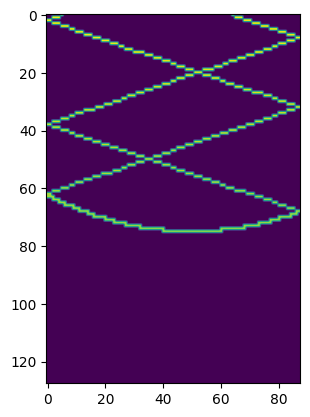

In [6]:
#%% Inputs
x_dim = 88
y_dim = 128
time_dimension = 1000
save_path = r"N:\Yr 3 Project Datasets\PDT 20K\Data\\"
num_of_files = 3
origin = None    #Set to none to have random origins, or input coordinates (x,y, ToF)




data = genrate_pdt_data_tensors(x_dim, y_dim, time_dimension, save_path, num_of_files, origin)
plt.imshow(data[0, 0, :, :])
plt.show()


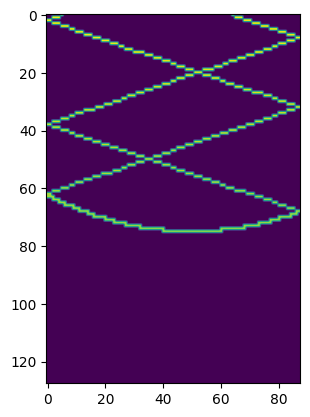

In [7]:
plt.imshow(data[0, 0, :, :])
plt.show()

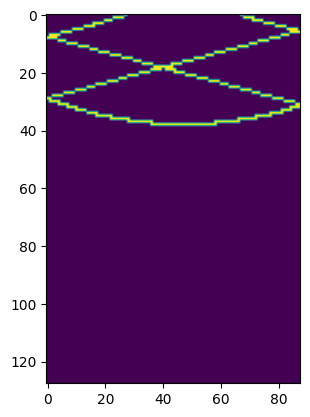

In [8]:
plt.imshow(data[1, 0, :, :])
plt.show()

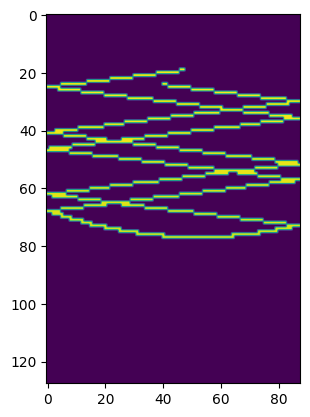

In [9]:
plt.imshow(data[2, 0, :, :])
plt.show()